In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import ghibtools as gh
import xarray as xr
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_global_dataframes import coherence_at_resp_concat_job, oas_concat_job, bmrq_concat_job
from bibliotheque import get_pos, init_nan_da, df_baseline, keep_clean, get_df_mask_chan_signif, cluster_stats
import mne
import os
from configuration import base_folder
from params import *

# LOAD DATA

In [3]:
pos = get_pos()

In [4]:
coherence = coherence_at_resp_concat_job.get(global_key).to_dataframe()

In [5]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_coherence','log_max_coherence']

In [6]:
coherence = coherence.set_index(indexes + ['Gender']).astype(float).reset_index()
coherence['log_max_coherence'] = np.log(coherence['max_coherence'])
coherence = keep_clean(coherence, metrics)

In [7]:
coherence

,index,participant,session,chan,Gender,fmax_resp,max_resp,max_coherence,stai_state,stai_trait,keep_session,Maia_Mean,OAS,BMRQ,log_max_coherence
0,0,P01,baseline,Fp1,F,0.356259,866.407169,0.013925,40.0,61.0,1.0,1.019643,2.666667,2.727273,-4.274095
1,1,P01,baseline,Fz,F,0.356259,866.407169,0.027888,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.579561
2,2,P01,baseline,F3,F,0.356259,866.407169,0.048918,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.017612
3,3,P01,baseline,F7,F,0.356259,866.407169,0.018114,40.0,61.0,1.0,1.019643,2.666667,2.727273,-4.011060
4,4,P01,baseline,FT9,F,0.356259,866.407169,0.032684,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.420880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2875,P31,odor,FC2,M,0.187505,3108.048063,0.046496,29.0,40.0,1.0,2.790774,2.933333,2.681818,-3.068388
2876,2876,P31,odor,F4,M,0.187505,3108.048063,0.148635,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.906264
2877,2877,P31,odor,F8,M,0.187505,3108.048063,0.059088,29.0,40.0,1.0,2.790774,2.933333,2.681818,-2.828728
2878,2878,P31,odor,Fp2,M,0.187505,3108.048063,0.002364,29.0,40.0,1.0,2.790774,2.933333,2.681818,-6.047208


In [8]:
coherence_baselined = df_baseline(coherence, indexes, metrics, mode = 'substract')

In [9]:
coherence_baselined

,participant,session,chan,fmax_resp,max_resp,max_coherence,log_max_coherence
0,P01,odor,Fp1,0.000000,-449.015372,0.001334,0.091509
1,P01,odor,Fz,0.000000,-449.015372,-0.010065,-0.447735
2,P01,odor,F3,0.000000,-449.015372,-0.028753,-0.886200
3,P01,odor,F7,0.000000,-449.015372,-0.011376,-0.988850
4,P01,odor,FT9,0.000000,-449.015372,-0.029334,-2.277960
...,...,...,...,...,...,...,...
1915,P31,music,FC2,-0.075002,3304.836158,0.164747,2.706743
1916,P31,music,F4,-0.075002,3304.836158,-0.019104,-0.545778
1917,P31,music,F8,-0.075002,3304.836158,0.009167,0.846347
1918,P31,music,Fp2,-0.075002,3304.836158,0.025271,0.518067


# STATS ENTRE CONDITIONS

<AxesSubplot: >

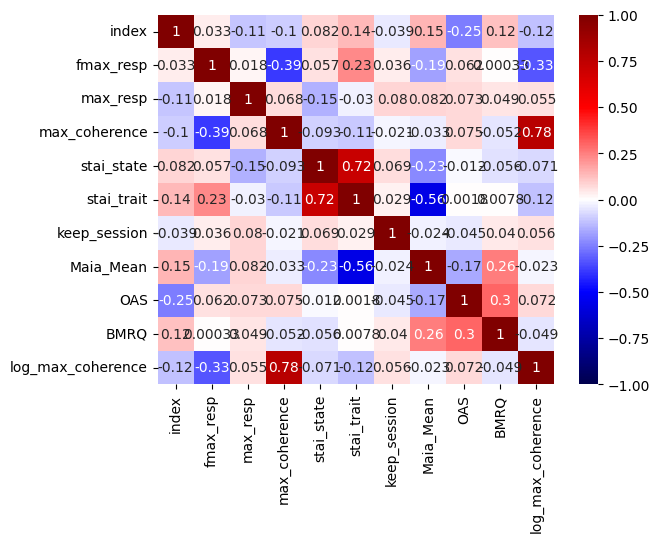

In [10]:
sns.heatmap(coherence.corr(numeric_only = True), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

<AxesSubplot: ylabel='Frequency'>

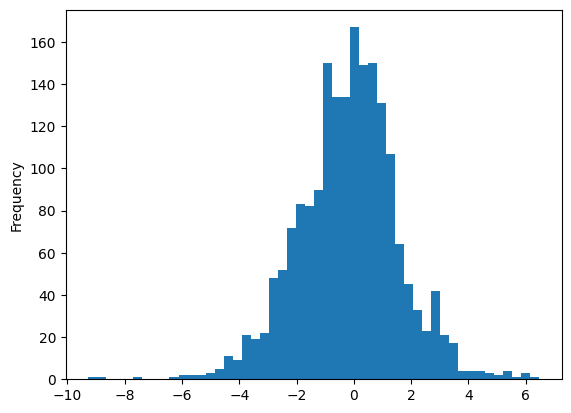

In [11]:
coherence_baselined['log_max_coherence'].plot.hist(bins = 50)

<AxesSubplot: ylabel='Frequency'>

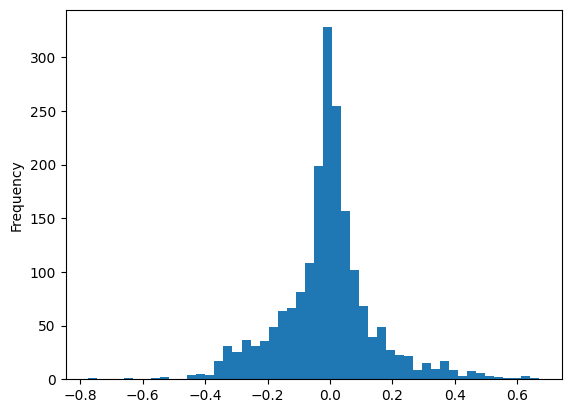

In [12]:
coherence_baselined['max_coherence'].plot.hist(bins = 50)

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


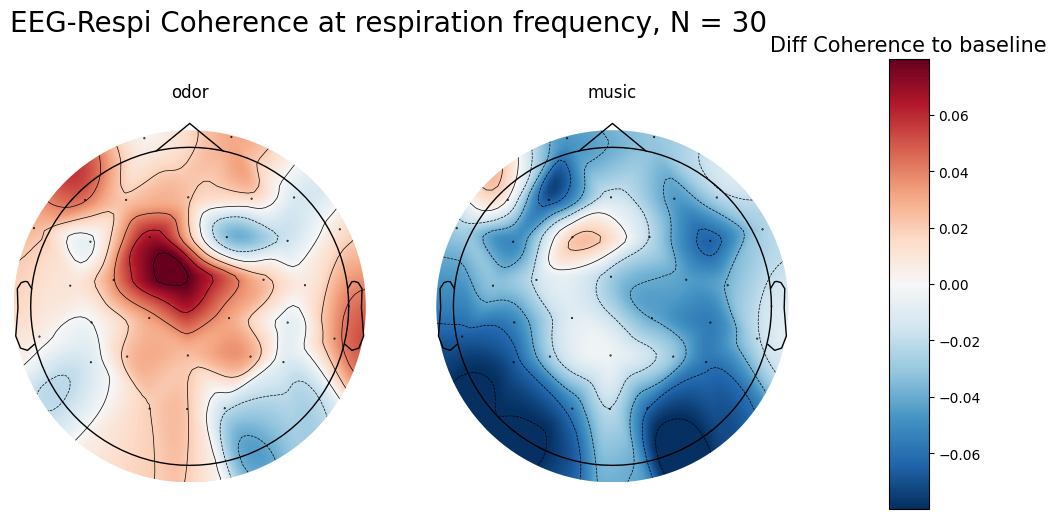

In [13]:
q_diff = 0.

metric = 'max_coherence'

df = coherence_baselined.copy()

mask_params = dict(markersize=18, markerfacecolor='y')
df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = metric, subject = 'participant', multicomp_method = 'bonf', stats_type = 'classic')


N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Diff Coherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'coherence_substract_baseline_stats_classiques.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

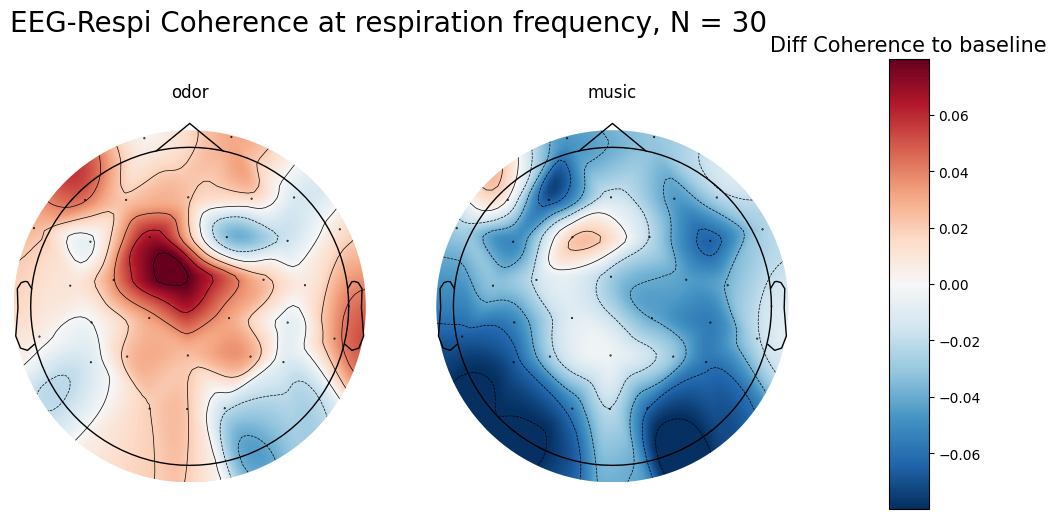

In [14]:
q_diff = 0.

metric = 'max_coherence'

df = coherence_baselined.copy()

mask_params = dict(markersize=18, markerfacecolor='y')
df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = metric, subject = 'participant', multicomp_method = 'bonf', stats_type = 'permutations')


N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Diff Coherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'coherence_substract_baseline_stats_permutations.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

In [15]:
oas = oas_concat_job.get(global_key).to_dataframe().set_index('participant')
bmrq = bmrq_concat_job.get(global_key).to_dataframe().set_index('participant')

In [16]:
q_diff = 0.

metric = 'max_coherence'

for subject in subject_keys:
    
    bmrq_sub = bmrq.loc[subject, 'BMRQ'].round(3)
    oas_sub = oas.loc[subject, 'OAS'].round(3)
    
    df = coherence_baselined[coherence_baselined['participant'] == subject]

    vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
    vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, sub = {subject} \n OAS : {oas_sub} - BMRQ : {bmrq_sub}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Coherence to baseline',fontsize=15)

    file = base_folder / 'Figures' / 'coherence_at_resp' / 'by_subject' / f'{subject}.png'
    

    fig.savefig(file, bbox_inches = 'tight')

    plt.close()

# STATS VS BASELINE

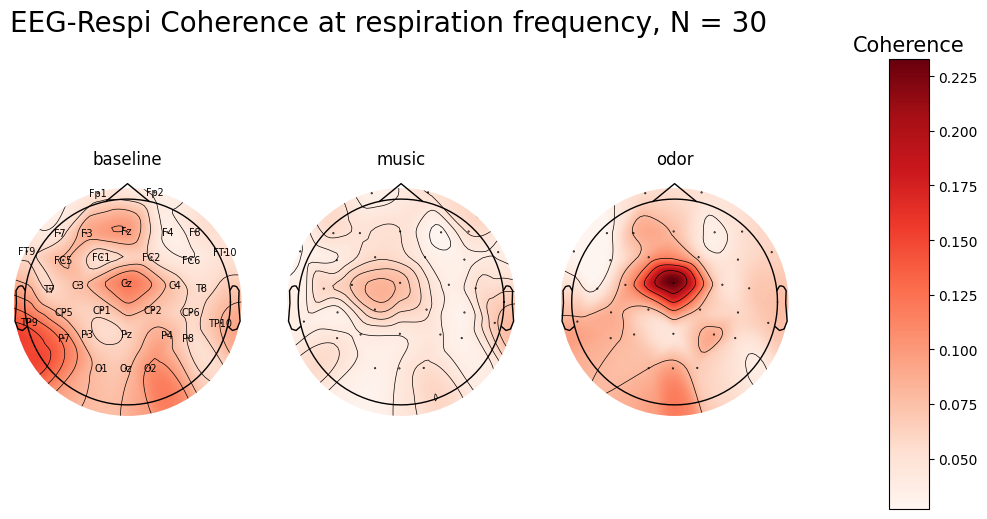

In [17]:
df = coherence.copy()

dfs_masks = []
for cond in ['odor','music']:
    df_to_mask = df[df['session'].isin(['baseline',cond])]
    df_mask = get_df_mask_chan_signif(df = df_to_mask, 
                                      chans = eeg_chans, 
                                      predictor = 'session',
                                      outcome = metric, 
                                      subject = 'participant',
                                      multicomp_method = 'bonf',
                                      stats_type = 'permutations',
                                      diff = 'median')
    df_mask['cond'] = cond
    dfs_masks.append(df_mask)
dfs_masks = pd.concat(dfs_masks)

mask_params = dict(markersize=15, markerfacecolor='y')

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(1 - q_diff)

# vmin = vmin if abs(vmin) > abs(vmax) else -vmax
# vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    df_mask = dfs_masks[dfs_masks['cond'] == session]
    topo_data = df[df['session'] == session].groupby('chan').median(numeric_only = True)[metric].reindex(eeg_chans)
    if session == 'baseline':
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    else:
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Coherence',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'raw_coherence_stats_permutations.png'
fig.savefig(file, bbox_inches = 'tight')
plt.show()

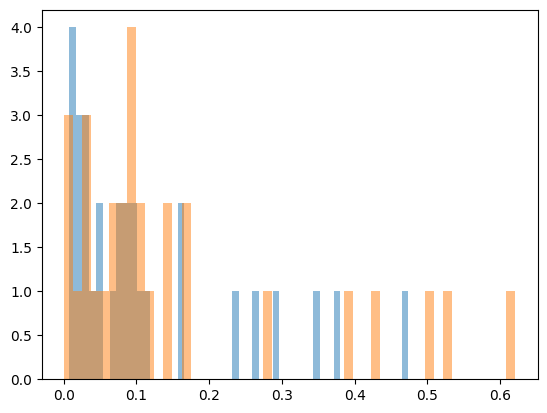

In [18]:
chan = 'C3'
x_df = df[(df['session'] == 'baseline') & (df['chan'] == chan)]
y_df = df[(df['session'] == 'odor') & (df['chan'] == chan)]
x = x_df['max_coherence'].values
y = y_df['max_coherence'].values

fig, ax = plt.subplots()
bins = 50
ax.hist(x, bins = bins, alpha = 0.5)
ax.hist(y, bins = bins, alpha = 0.5)
plt.show()

In [19]:
x

array([0.04630391, 0.03018477, 0.10128021, 0.01181155, 0.02411105,
       0.23623719, 0.1584931 , 0.29552407, 0.04297801, 0.02433335,
       0.3785594 , 0.09276258, 0.00724265, 0.08885025, 0.4736472 ,
       0.06676482, 0.25918282, 0.09062021, 0.04874463, 0.15964999,
       0.02872018, 0.11148062, 0.01658188, 0.00929223, 0.01247027,
       0.07580352, 0.0737846 , 0.03393183, 0.34585013, 0.10035996])

In [20]:
y

array([0.00812525, 0.1106446 , 0.09561867, 0.08753996, 0.38911782,
       0.09402094, 0.5300499 , 0.43316783, 0.09351566, 0.50354597,
       0.62052478, 0.16693261, 0.10736542, 0.28230131, 0.04423639,
       0.07000983, 0.14784126, 0.03281899, 0.01695826, 0.11381683,
       0.00409912, 0.02626785, 0.13844849, 0.05191276, 0.08391891,
       0.00086051, 0.03365604, 0.09742408, 0.17094567, 0.06397072])

In [21]:
from scipy import stats

In [22]:
def statistic(x,y):
    return np.median(x) - np.median(y)

In [23]:
res = stats.permutation_test(data=[x,y], statistic=statistic, permutation_type='samples', n_resamples=1000)

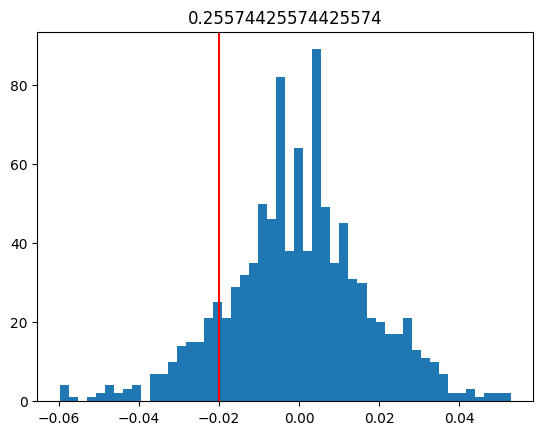

In [24]:
fig, ax = plt.subplots()
ax.hist(res.null_distribution, bins = 50)
ax.axvline(statistic(x,y), color = 'r')
ax.set_title(res.pvalue)
plt.show()

# MNE CLUSTER STATS


Xlist of array, shape (n_observations, p[, q][, r])
The data to be clustered. Each array in X should contain the observations for one group. The first dimension of each array is the number of observations from that group; remaining dimensions comprise the size of a single observation. For example if X = [X1, X2] with X1.shape = (20, 50, 4) and X2.shape = (17, 50, 4), then X has 2 groups with respectively 20 and 17 observations in each, and each data point is of shape (50, 4). Note: that the last dimension of each element of X should correspond to the dimension represented in the adjacency parameter (e.g., spectral data should be provided as (observations, frequencies, channels/vertices)).


In [25]:
import scipy
import xarray as xr

In [26]:
df

,index,participant,session,chan,Gender,fmax_resp,max_resp,max_coherence,stai_state,stai_trait,keep_session,Maia_Mean,OAS,BMRQ,log_max_coherence
0,0,P01,baseline,Fp1,F,0.356259,866.407169,0.013925,40.0,61.0,1.0,1.019643,2.666667,2.727273,-4.274095
1,1,P01,baseline,Fz,F,0.356259,866.407169,0.027888,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.579561
2,2,P01,baseline,F3,F,0.356259,866.407169,0.048918,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.017612
3,3,P01,baseline,F7,F,0.356259,866.407169,0.018114,40.0,61.0,1.0,1.019643,2.666667,2.727273,-4.011060
4,4,P01,baseline,FT9,F,0.356259,866.407169,0.032684,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.420880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2875,P31,odor,FC2,M,0.187505,3108.048063,0.046496,29.0,40.0,1.0,2.790774,2.933333,2.681818,-3.068388
2876,2876,P31,odor,F4,M,0.187505,3108.048063,0.148635,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.906264
2877,2877,P31,odor,F8,M,0.187505,3108.048063,0.059088,29.0,40.0,1.0,2.790774,2.933333,2.681818,-2.828728
2878,2878,P31,odor,Fp2,M,0.187505,3108.048063,0.002364,29.0,40.0,1.0,2.790774,2.933333,2.681818,-6.047208


In [27]:
ch_names = df['chan'].unique()
da = gh.init_da({'session':df['session'].unique(), 'participant':df['participant'].unique(), 'chan':ch_names})
for ses in da['session'].values:
    for participant in da['participant'].values:
        for chan in da['chan'].values:
            da.loc[ses,participant,chan] = df.set_index(['session','participant','chan']).loc[(ses,participant,chan),'max_coherence']

In [28]:
da

<xarray.DataArray (session: 3, participant: 30, chan: 32)>
array([[[0.01392464, 0.02788793, 0.04891791, ..., 0.0436371 ,
         0.00730138, 0.13332917],
        [0.00574332, 0.02785459, 0.21356917, ..., 0.16806066,
         0.1798222 , 0.02368746],
        [0.08326274, 0.17420585, 0.37927784, ..., 0.13099438,
         0.07505772, 0.14419818],
        ...,
        [0.13810279, 0.21864586, 0.09151499, ..., 0.21005683,
         0.15033815, 0.12851057],
        [0.34585013, 0.34585013, 0.34585013, ..., 0.34585013,
         0.34585013, 0.34585013],
        [0.04763489, 0.11461042, 0.04828279, ..., 0.00688652,
         0.03722961, 0.02018605]],

       [[0.10090051, 0.01983541, 0.02576012, ..., 0.03328561,
         0.05885794, 0.08667004],
        [0.02368746, 0.02368746, 0.02368746, ..., 0.02368746,
         0.02368746, 0.02368746],
        [0.07498961, 0.12811355, 0.07241163, ..., 0.01916529,
         0.06134521, 0.40745382],
...
        [0.00143004, 0.02299995, 0.01176448, ..., 0.01512359,
         0.0583743 , 0.00592515],
        [0.01900222, 0.00476798, 0.05278046, ..., 0.16382555,
         0.0216572 , 0.09400895],
        [0.04510551, 0.33767233, 0.09547963, ..., 0.01605326,
         0.06250028, 0.3853857 ]],

       [[0.01525899, 0.01782245, 0.0201649 , ..., 0.01940975,
         0.03145513, 0.03061045],
        [0.09896887, 0.32464628, 0.0235374 , ..., 0.0954283 ,
         0.09840182, 0.23999259],
        [0.02135897, 0.05383605, 0.14378603, ..., 0.30559024,
         0.02031634, 0.15601334],
        ...,
        [0.44443866, 0.18561583, 0.48102843, ..., 0.09635323,
         0.22743263, 0.34585013],
        [0.07320325, 0.23457681, 0.1721148 , ..., 0.09028832,
         0.0514134 , 0.23886348],
        [0.00141423, 0.20194344, 0.03268535, ..., 0.05908799,
         0.00236445, 0.37460495]]])
Coordinates:
  * session      (session) object 'baseline' 'music' 'odor'
  * participant  (participant) object 'P01' 'P02' 'P03' ... 'P29' 'P30' 'P31'
  * chan         (chan) object 'Fp1' 'Fz' 'F3' 'F7' ... 'F4' 'F8' 'Fp2' 'Cz'

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 32


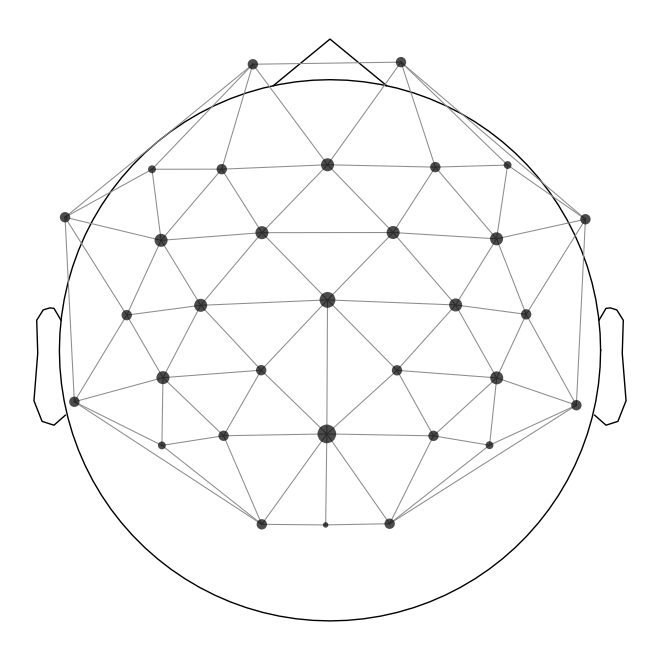

In [29]:
adjacency, ch_names = mne.channels.find_ch_adjacency(pos, ch_type = 'eeg')
mne.viz.plot_ch_adjacency(pos, adjacency, ch_names, kind = '2d')
plt.show()

In [30]:
x1 = da.sel(session = 'baseline').values
x2 = da.sel(session = 'music').values
X = x2 - x1

stat_fun = None

t_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(X, 
                                                                           threshold=None, 
                                                                           stat_fun=stat_fun, 
                                                                           adjacency=None, 
                                                                           out_type = 'indices')


res = {p:{'chan_inds':cluster[0],'chan_labels':np.array(ch_names)[cluster[0]]} for cluster, p in zip(clusters, cluster_p_values)}
n_cluster_signif = sum(cluster_p_values < 0.05)
print(f'{n_cluster_signif} cluster(s) significant')

Using a threshold of 2.045230
stat_fun(H1): min=-3.055056 max=0.575203
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

0 cluster(s) significant


In [31]:
# x1 = da.sel(session = 'baseline').values
# x2 = da.sel(session = 'music').values
# x3 = da.sel(session = 'odor').values
# # X = [logit(x1), logit(x2),logit(x3)]
# X = [x1, x2, x3]

# # stat_fun = None
# # stat_fun = stats.ttest_rel

# def friedman(X):
#     res, p = scipy.stats.friedmanchisquare(X[0],X[1],X[2])
#     return res

# stat_fun = friedman

# F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, 
#                                                                            threshold=None, 
#                                                                            stat_fun=stat_fun, 
#                                                                            adjacency=adjacency, 
#                                                                            n_permutations = 1024,
#                                                                            out_type = 'mask',
#                                                                           seed = 30)

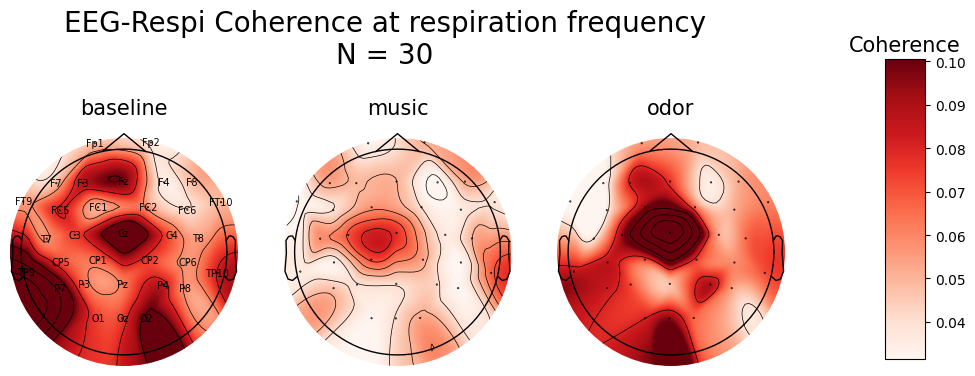

In [32]:
df = coherence.copy()

q_diff = 0.05

mask_params = dict(markersize=15, markerfacecolor='y')
# mask_params = None

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(1 - q_diff)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency\nN = {N}', fontsize = 20, y = 1)

chans = da['chan'].values

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').median(numeric_only = True)[metric].reindex(chans)
    if session == 'baseline':
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = chans, axes = ax, show = False, vlim = (vmin,vmax))
    else:
        x1 = da.sel(session = 'baseline').values
        x2 = da.sel(session = session).values
        mask = cluster_stats(x1,x2,chans)
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = chans, axes = ax, show = False, vlim = (vmin,vmax), mask = mask, mask_params = mask_params)
    ax.set_title(f'{session}', fontsize = 15)
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.3
ax_y_height = 0.6
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Coherence',fontsize=15)

fig.savefig(base_folder / 'Figures' / 'coherence_at_resp' / 'coherence_at_resp_cluster_stats.png', dpi = 300, bbox_inches = 'tight')

plt.show()